In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers

# Load and prepare data
tr, val, ts = util.load_restaurant_data()
dt_in = ['avg_rating', 'num_reviews', 'dollar_rating']

nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()

tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

2023-07-11 16:23:50.706530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 16:23:50.742022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 16:23:50.742771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 16:23:51.511995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Lattice Models to Support Constraints

## Lattice Models

**We will deal with the constraint by relying on a Lattice model**

Lattice models are a form of piecewise linear interpolated model

<center><img src="assets/lattice.png" width=30%/></center>

* They are defined via _a grid_ over their input variables
* Their parameters are _the output values at each grid point_
* Other output values are obtained via _linear interpolation_

## Lattice Models

**Lattice models:**

* Can represent non-linear multivariate functions
* Can be trained by (e.g.) gradient descent

**The grid is defined by splitting each input domain into _intervals_**

* The domain of variable $x_i$ is split by choosing a fixed set of $n_i$ "knots"
* ...Of course this leads to _scalability issues_: we will discuss them later

**The lattice parameters are _interpretable_**

They simply represent output values for certain input vectors 

* They can be changed with _predictable effects_
* They can be _constrained_ so that the model behaves in a desired fashion
* If we use hard constraints, we get a _guaranteed behavior_

## Lattice Models and Interpretability

**Interpretability is a major open issue in modern ML**

It is often _a key requirement in industrial applications_

* Customers have trouble accepting models that they do not understand
* Sometimes you are legally bound to provide motivations


**There are two main ways to achieve interpretability**

The first is using a model that is _inherently interpretable_

* There are _a few examples of this_: linear regression, DTs, (some) SVMs, rules...
* Lattice models fall into this class

The second approach is computing a posteriori _explanations_

* E.g. approximate linear explanations
* ...Such as in the [LIME](https://homes.cs.washington.edu/~marcotcr/blog/lime/) or [SHAP](https://shap.readthedocs.io/en/latest/) approaches

# Combining Lattice Models

## Combining Lattice Models

**Using a single lattice model leads to scalability issues**

In a lattice model, the number of grid points is given by:

$$
n = \prod_{i=1}^m n_i
$$

* ...Hence the parameter number scales _exponentially_ with the number of inputs
* So that modeling complex non-linear function seems to come at a steep cost

**Scalability issues can be mitigated via two approaches:**

* Ensembles of small lattices (we will not cover this one)
* Processing _each input variable individually_ using a smaller Lattice

We will focus on this latter approach, which is sometimes called "calibration"

## Calibration for Numeric Inputs

**Calibration for _numeric attributes_...**

...Consists in applying a _piecewise linear transformation_ to each input

<center><img src="assets/pwl.png" width=600px/></center>

* This is in fact a 1-D lattice
* Calibration _parameters_ are the function values at _all knots_

## Calibration for Categorical Inputs

**Calibration for _categorical inputs_...**

...Consists in applying a map:

<center><img src="assets/BarChart.png" width=700px/></center>

* Categorical inputs must be encodeded as integers
* Each input value is mapped to an output value
* The _parameters_ are the _map output values_

## About Calibration

**With this approach:**

* We make each _input_ more complicated
* ...Which allows us to make the _lattice_ model simple

**Calibration enables the use of _fewer knots in the lattice_**

E.g. say we are aiming for 5 grid values per attribute, with 2 attributes

* With 5 knots per layer an single lattice: $5 \times 5 = 25$ parameters
* With 5 calibration knots + 2 lattice knots: $5\times 2 + 2 \times 2 = 14$

**We do not get the same level of flexibility, but we get close**

* Additionally, we tend to get _more regular results_
* ...Since we have more bias and less variance

This might be an advantage for out-of-distribution generalization

## Data Preprocessing

**As usual, we need to start with some data pre-processing**

We start by converting our string data into integers

In [2]:
tr_sc2 = tr_s.copy()
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].astype('category')
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].cat.codes
tr_sc2['dollar_rating'][:3]
val_sc2 = val_s.copy()
val_sc2['dollar_rating'] = val_sc2['dollar_rating'].astype('category').cat.codes
ts_sc2 = ts_s.copy()
ts_sc2['dollar_rating'] = ts_sc2['dollar_rating'].astype('category').cat.codes

tr_sc2[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,0.785773,0.61,3,1
1,0.785773,0.61,3,0
2,0.785773,0.61,3,0


## Implementing a Lattice Model

**Now we need to choose the size for the main lattice**

In [3]:
lattice_sizes = [2] * 3

* We will use only two knots per dimension
* Since most of the complex processing will be done by calibration

**Then we separate the features and we build individual input tensors**

In [4]:
tr_ls2 = [tr_sc2[c] * (s-1) for c, s in zip(dt_in, lattice_sizes)]
val_ls2 = [val_sc2[c] * (s-1) for c, s in zip(dt_in, lattice_sizes)]
ts_ls2 = [ts_sc2[c] * (s-1) for c, s in zip(dt_in, lattice_sizes)]

avg_rating = layers.Input(shape=[1], name='avg_rating')
num_reviews = layers.Input(shape=[1], name='num_reviews')
dollar_rating = layers.Input(shape=[1], name='dollar_rating')

* This is needed for compatibility with the tensorflow-lattice implementation

## Piecewise Linear Calibration

**We use `PWLCalibration` objects for all numeric inputs**

In [5]:
import tensorflow_lattice as tfl

avg_rating_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc2['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes[0] - 1.0, name='avg_rating_cal'
)(avg_rating)

num_reviews_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes[1] - 1.0, name='num_reviews_cal'
)(num_reviews)

* The knot _values are learnable_ parameters
* ...But their positions are fixed (in this case to specific quantiles)

## Categorical Calibration

**We use `CategoricalCalibration` objects for the categorical input**

In [6]:
dollar_rating_cal = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes[2] - 1.0,
    name='dollar_rating_cal'
)(dollar_rating)

* We use one "bucket" for each possible category

**Finally, we build the actual lattice**

In [7]:
lt_inputs = [avg_rating_cal, num_reviews_cal, dollar_rating_cal]

mdl_out = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    output_min=0, output_max=1, name='lattice',
)(lt_inputs)

mdl_inputs = [avg_rating, num_reviews, dollar_rating]
lm = keras.Model(mdl_inputs, mdl_out)

## Building the Calibrated Lattice Model

**Let's see which kind of architecture we have now:**

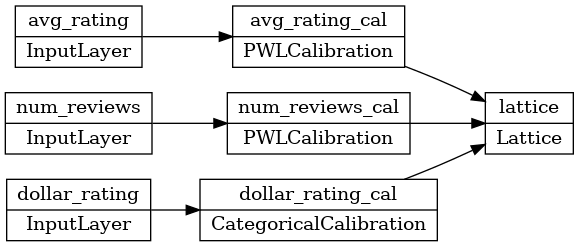

In [9]:
util.plot_nn_model(lm, show_layer_activations=True, show_layer_names=True, show_shapes=False)

## Training the Calibrated Lattice

**We can train the new model as usual**

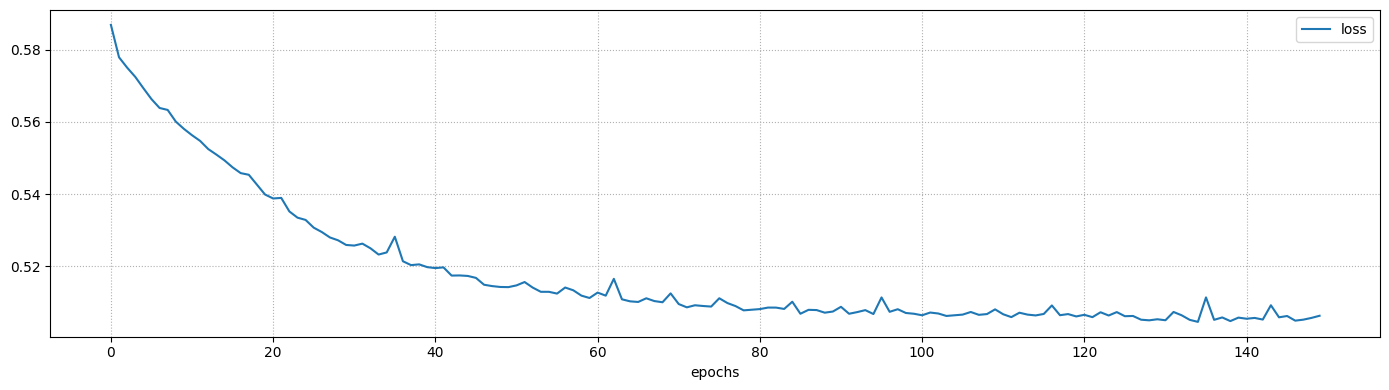

Final loss: 0.5063 (training)


In [10]:
history = util.train_nn_model(lm, tr_ls2, tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=150, verbose=0)
util.plot_training_history(history, figsize=figsize)

## Evaluating the Calibrated Lattice

**...And finally we can evaluate the results**

In [11]:
pred_tr2 = lm.predict(tr_ls2, verbose=0)
pred_val2 = lm.predict(val_ls2, verbose=0)
pred_ts2 = lm.predict(ts_ls2, verbose=0)
auc_tr2 = roc_auc_score(tr_s['clicked'], pred_tr2)
auc_val2 = roc_auc_score(val_s['clicked'], pred_val2)
auc_ts2 = roc_auc_score(ts_s['clicked'], pred_ts2)
print(f'AUC score: {auc_tr2:.2f} (training), {auc_val2:.2f} (validation), {auc_ts2:.2f} (test)')

AUC score: 0.80 (training), 0.80 (validation), 0.80 (test)


* The performance is on par with the original one
* ...Except on the test set, where it works _much better_

## Inspecting the Calibrated Lattice

**We can _inspect the learned function_ visually to get a better insight**

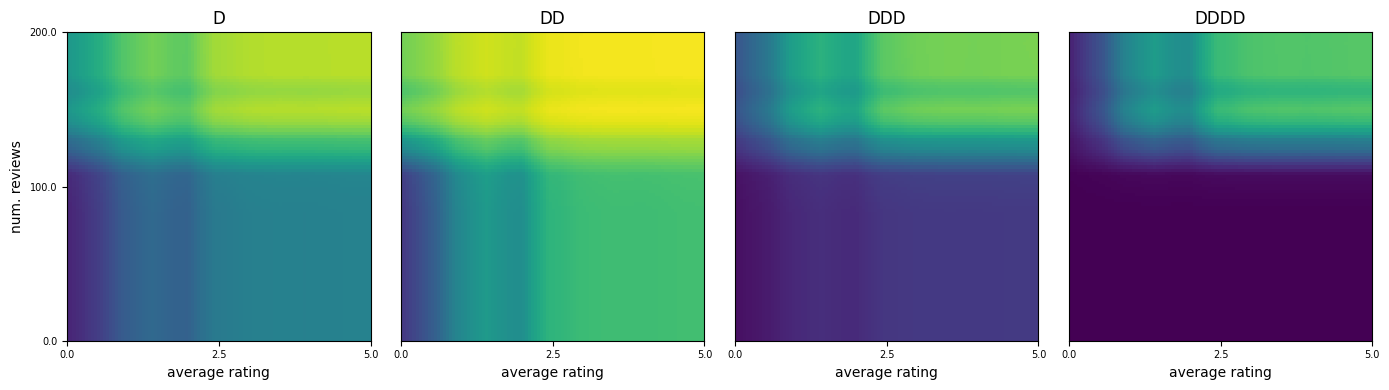

In [12]:
util.plot_ctr_estimation(lm, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* The structure follows a (piecewise linear) "tartan pattern" 
* This is particularly evident now, since we use just two knots per dimension

## Inspecting the Calibrated Lattice

**It is useful to _inspect the calibration layers_**

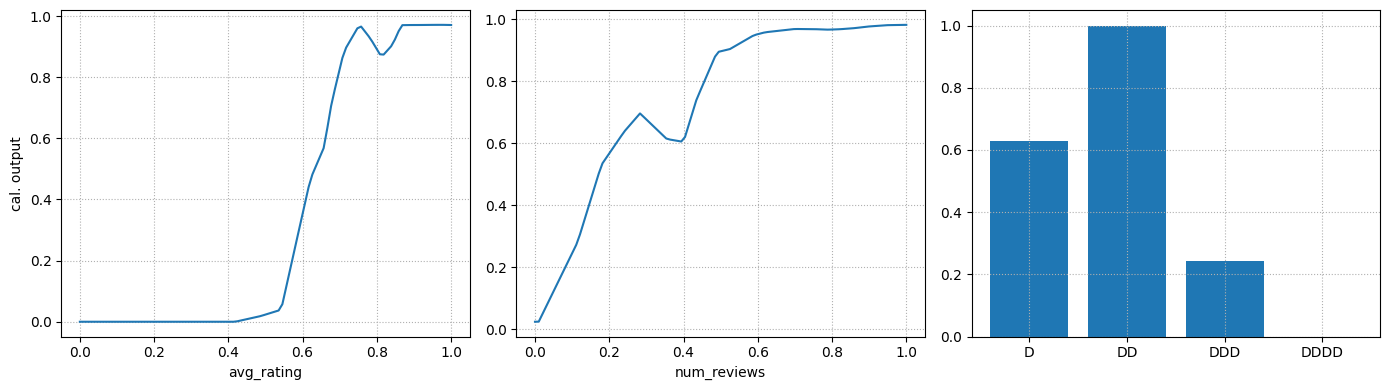

In [14]:
calibrators = [keras.Model(mdl_inputs[i], lt_inputs[i]) for i in range(3)]
util.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* The learned calibration functions violate the expected monotonicities
* ...Meaning that we still have one problem to solve

# Shape Constraints

## Shape Constraints

**Lattice models are well suited to deal with _shape constraints_**

Shape constraints are restrictions on the input-output function, such as:

* Monotonicity (e.g. "the output should grow when an input grows")
* Convexity/concavity (e.g. "the output should be convex w.r.t. an input")

**Shape constraints are _very common_ in industrial applications**

Some examples:

* Reducing the price will raise the sales volume (monotonicity)
* Massive price reductions will be less effective (diminishing returns)
* Too low/high temperatures will lead to worse bakery products (convexity)

**We can use them to fix our calibration issues**

## Shape Constraints

**Shape constraints translate into _constraints on the lattice parameters_**

* Let $\theta_{i, k, \bar{i}, \bar{k}}$ be the parameter for the $k$-th knot of input $i$...
* ...While all the remaining attributes and knots (i.e. $\overline{i}$ and $\overline{k}$) are fixed

**Then (increasing) _monotonicity_ translates to:**
$$
\theta_{i,k,\bar{i},\bar{k}} \leq \theta_{i,k+1,\bar{i},\bar{k}}
$$

* I.e. all else being equal, the lattice value at the grid points must be increasing
* Decreasing monotonicity is just the inverse

**Then _convexity_ translates to:**
$$
\left(\theta_{i,k+1,\bar{i},\bar{k}} - \theta_{i,k,\bar{i},\bar{k}}\right) \leq \left(\theta_{i,k+2,\bar{i},\bar{k}} - \theta_{i,k+1,\bar{i},\bar{k}}\right)
$$

* I.e. all else being equal, the adjacent parameter differences should increase

## Monotonicity and Smoothness

**We can expect a monotonic effect of the average rating**

I.e. Restaurants with a high rating will be clicked more often

In [16]:
avg_rating2 = layers.Input(shape=[1], name='avg_rating')
avg_rating_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes[0] - 1.0,
    monotonicity='increasing',
    kernel_regularizer=('hessian', 0, 1),
    name='avg_rating_cal'
)(avg_rating2)

**In addition to monotonicity, we use a Hessian regularizer:**

* This is a regularization term that penalizes the second derivative
* ...Thus making the calibrator more linear
* The two parameters are an L1 weight and L2 weights

## Diminishing Returns

**We can expect a diminishing returns from the number of reviews**

* I.e. 200 reviews will be linked to much more clicks than 10 reviews
* ...But only a little more than 150 reviews

In [18]:
num_reviews2 = layers.Input(shape=[1], name='num_reviews')
num_reviews_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes[1] - 1.0,
    monotonicity='increasing',
    convexity='concave',
    kernel_regularizer=('wrinkle', 0, 1),
    name='num_reviews_cal'
)(num_reviews2)

**By coupling monotonicity with concavity we enforce diminishing returns**

* We also use the "wrinkle" reguralizer, which penalizes the third derivative
* ...Thus making the calibration function smoother

## Partial Orders on Categories

**We can expect more clicks for reasonably priced restaurants...**

...At least compared to very cheap and very expensive ones

In [19]:
dollar_rating2 = layers.Input(shape=[1], name='dollar_rating')
dollar_rating_cal2 = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes[2] - 1.0,
    monotonicities=[(0, 1), (3, 1)],
    name='dollar_rating_cal'
)(dollar_rating2)

**On categorical attributes, we can enforce _partial order constraints_**

* Each $(i, j)$ pair translates into an inequality $\theta_i \leq \theta_j$
* Here we specify that "D" and "DDDD" will tend to have fewer clicks than "DD"

## Lattice Model with Shape Constraints

**Then we can build the actual lattice model**

In [21]:
lt_inputs2 = [avg_rating_cal2, num_reviews_cal2, dollar_rating_cal2]

mdl_out2 = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    output_min=0, output_max=1,
    monotonicities=['increasing'] * 3, name='lattice',
)(lt_inputs2)

mdl_inputs2 = [avg_rating2, num_reviews2, dollar_rating2]
lm2 = keras.Model(mdl_inputs2, mdl_out2)

**If we specify monotonicities in the calibration layers**

...Then the lattice _must be monotone, too_

* Otherwise, we risk loosing all our benefits
* Lattice monotonicities are always _set to "increasing"_
* ...Since we just want to _preserve monotonicities_ from the calibration layers

## Lattice Model with Shape Constraints

**Let's train the constrained model**

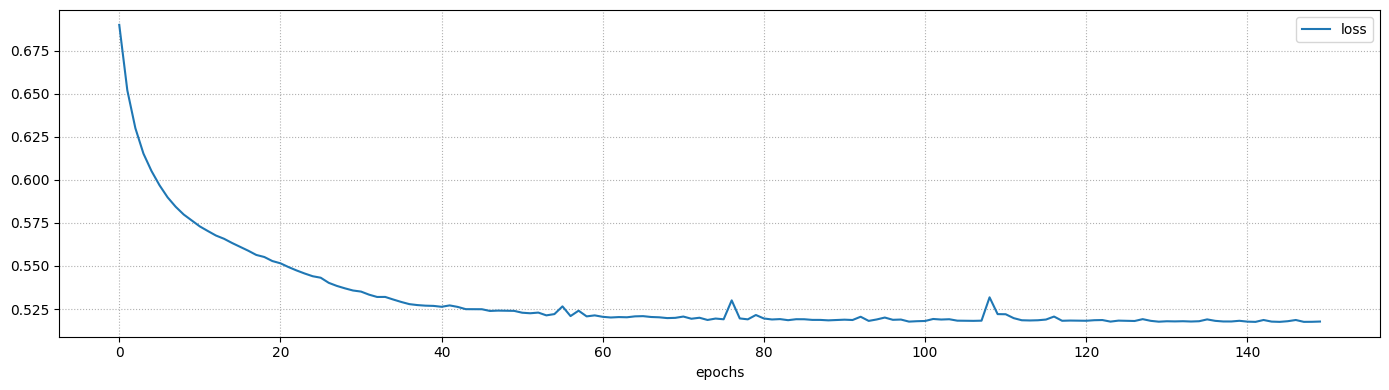

Final loss: 0.5177 (training)


In [22]:
history = util.train_nn_model(lm2, tr_ls2, tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=150, verbose=0)
util.plot_training_history(history, figsize=figsize)

## Evaluating the Lattice Model with Shape Constraints

In [23]:
pred_tr3 = lm2.predict(tr_ls2, verbose=0)
pred_val3 = lm2.predict(val_ls2, verbose=0)
pred_ts3 = lm2.predict(ts_ls2, verbose=0)
auc_tr3 = roc_auc_score(tr_s['clicked'], pred_tr2)
auc_val3 = roc_auc_score(val_s['clicked'], pred_val2)
auc_ts3 = roc_auc_score(ts_s['clicked'], pred_ts2)
print(f'AUC score: {auc_tr3:.2f} (training), {auc_val3:.2f} (validation), {auc_ts3:.2f} (test)')

AUC score: 0.80 (training), 0.80 (validation), 0.80 (test)


The results are on par with the previous ones

## Inspecting the Calibrated Lattice

**Let's inspect the learned function**

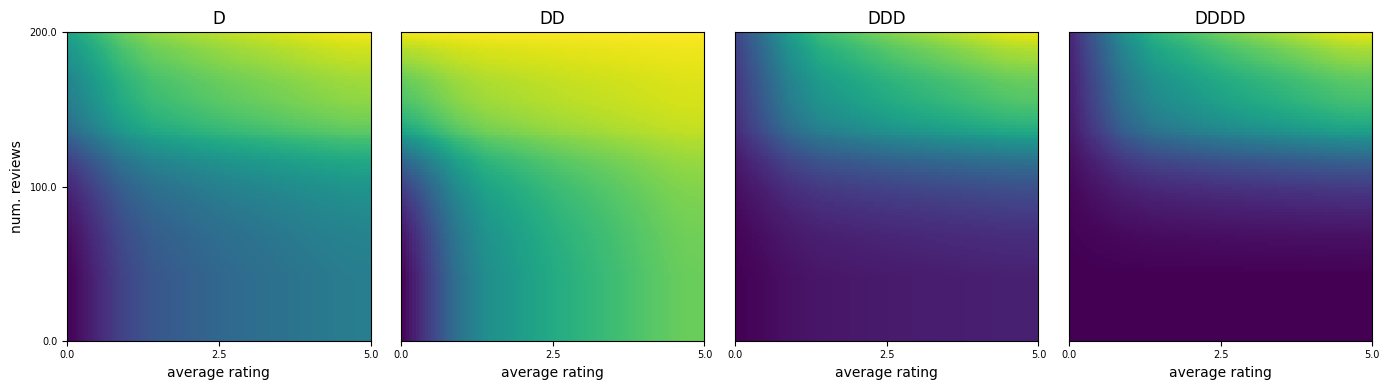

In [24]:
util.plot_ctr_estimation(lm2, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* All _monotonicities are respected_, the functions are much more regular
* Tartan-pattern apart, they closely match our ground truth

## Inspecting the Calibrated Lattice

**The most interesting changes will be in the calibration functions**

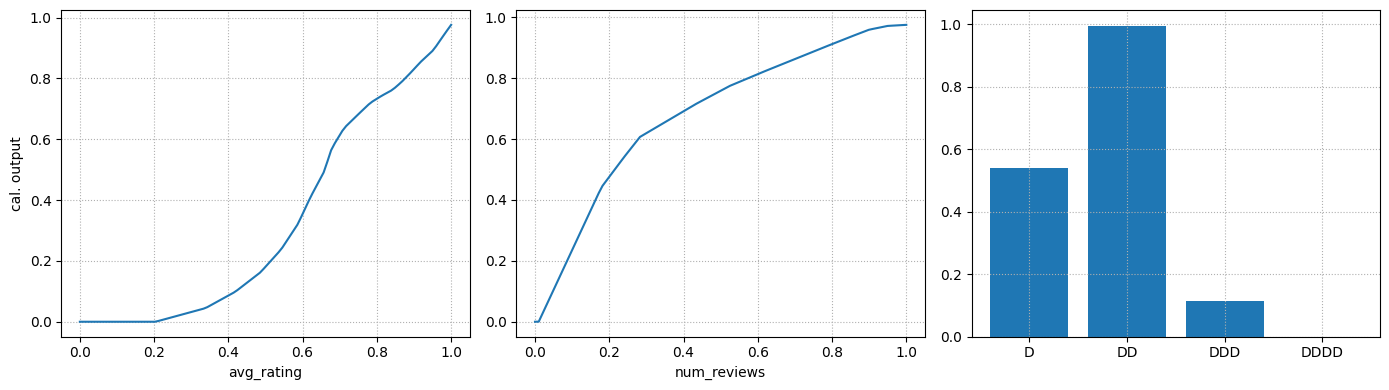

In [25]:
calibrators = [keras.Model(mdl_inputs2[i], lt_inputs2[i]) for i in range(3)]
util.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* Indeed, all monotonicities are respected
* The `avg_rating` regularizer is more linear
* The `num_reviews` one is convex and smooth

## Considerations

**Lattice models are little known, but they can be _very useful_**

* They are interpretable
* Customer react (very) poorly to violation of known properties

**In general, shape constraints are related to the topic of _reliability_**

* I.e. the ability of a ML model to respect basic properties
* ...Especially in areas of the input space not well covered by the training set

Reliability is a very important topic for many applications of AI methods

**Calibration is _not restricted to the lattice input_**

* Indeed, we can add a calibration layer on the output as well
* ...So that we gain flexibility at a cost of a few more parameters